In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
# import keras_tuner as kt
from tensorflow.keras.utils import to_categorical


In [ ]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
from google.colab import drive
drive.mount('/content/drive')

# # kaggle vagitable image 데이터셋 다운로드
!unzip '/content/drive/MyDrive/archive.zip' -d /content/dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0013.jpg  
  inflating: /content/dataset/Vegetable I

In [ ]:
# 학습(train), 테스트(test), 검증(validation) 데이터셋 경로 지정
train_dir = 'dataset/Vegetable Images/train'
test_dir = 'dataset/Vegetable Images/test'
val_dir = 'dataset/Vegetable Images/validation'

In [ ]:
# # MobileNetV2 파라미터
image_size = (224, 224)
batch_size = 32

# 학습 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255, # 픽셀 정규화
    rotation_range=20, # 1~20 무작위 회전
    width_shift_range=0.2, # 수평 방향 이동
    height_shift_range=0.2, # 수직 방향 이동
    shear_range=0.2, # 전단 변환
    zoom_range=0.2, # 확대, 축소
    horizontal_flip=0.2, # 뒤집기
    fill_mode='nearest', # 이미지 변형 중 빈 공간 채우기
)

# 테스트, 검증 데이터 정규화
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
# 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_tuning.keras')
model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,755,695 (10.51 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 331,808 (1.27 MB)

In [ ]:
# prompt: 모델의 학습 과정인 학습 시작, 종료 시각, 에포크 번호, 손실 함수값과 정확도를 구글 드라이브에 저장할 수 있는 코드를 작성해줘

import pandas as pd
import datetime

best_lr = 0.0009497969456542987
best_bs = 64

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모든 레이어를 학습 가능하도록 설정 (Fine-tuning)
for layer in base_model.layers:
  layer.trainable = True

# 최종 학습을 위한 콜백 정의 (필요에 따라 조정)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
checkpoint_path = os.path.join('/content/drive/My Drive/models', 'best_model_mobilenetv2.keras')
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1) # 가중치 저장

# 학습률을 줄여서 Fine-tuning 진행
model.compile(optimizer=Adam(learning_rate=best_lr / 10),  # 학습률을 1/10로 줄임
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 학습 로그를 저장할 파일 경로
log_file_path = '/content/drive/My Drive/training_log.csv'

# 학습 시작 시간 기록
start_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 학습 로그를 저장할 리스트 초기화
log_data = []

# Fine-tuning 학습 진행
for epoch in range(20):
  print(f"Epoch {epoch+1}/20")
  history = model.fit(train_generator, epochs=1, batch_size=best_bs,
                      validation_data=val_generator, callbacks=[early_stopping, reduce_lr, checkpoint])

  # 현재 에포크의 손실 함수값과 정확도 가져오기
  loss = history.history['loss'][-1]
  accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  # 로그 데이터 추가
  log_data.append([start_time, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), epoch + 1, loss, accuracy, val_loss, val_accuracy])

# 학습 종료 시간 기록
end_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 로그 데이터를 데이터프레임으로 변환
log_df = pd.DataFrame(log_data, columns=['Start Time', 'End Time', 'Epoch', 'Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy'])

# 로그 데이터를 CSV 파일로 저장
log_df.to_csv(log_file_path, index=False)

model_save_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_full_fine_tuning.keras')
model.save(model_save_path)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 85/469 ━━━━━━━━━━━━━━━━━━━━ 12:10 2s/step - accuracy: 0.9917 - loss: 0.0333

KeyboardInterrupt: 

In [ ]:
# 학습 그래프 시각화 정의
def plot_learning_curves(history):
  plt.figure(figsize=(12, 4))

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.ylim(0, 1)  # Set the y-axis range for accuracy from 0 to 1

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9980 - loss: 0.0049
✅ Test loss: 0.00459270877763629
✅ Test accuracy: 0.9983333349227905


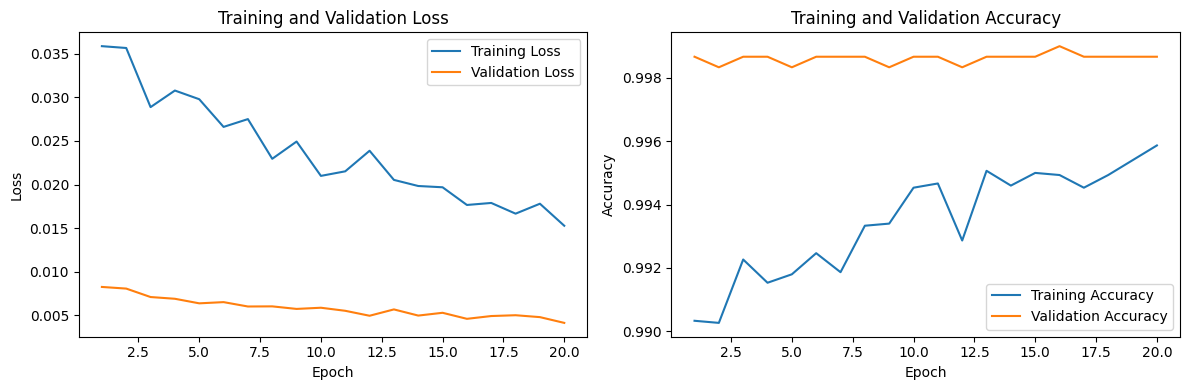

In [ ]:
# prompt: 위에 저장된 training_log 파일을 로드해서 학습 과정의 loss, accuracy 값을 그래프로 시각화해주는 코드를 작성해줘

import pandas as pd
import matplotlib.pyplot as plt

# 학습 로그 파일 경로
log_file_path = '/content/drive/My Drive/training_log.csv'

# 학습 로그 파일 로드
log_df = pd.read_csv(log_file_path)

# 에포크에 따른 손실 및 정확도 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(log_df['Epoch'], log_df['Loss'], label='Training Loss')
plt.plot(log_df['Epoch'], log_df['Val_Loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log_df['Epoch'], log_df['Accuracy'], label='Training Accuracy')
plt.plot(log_df['Epoch'], log_df['Val_Accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2_full_fine_tuning.keras')
loaded_model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,755,695 (10.51 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 331,808 (1.27 MB)

In [ ]:
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9980 - loss: 0.0049
✅ Test loss: 0.00459270877763629
✅ Test accuracy: 0.9983333349227905


In [ ]:
# 데이터 예측
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = loaded_model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step


In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      0.99       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       1.00      1.00      1.00       200
    Broccoli       1.00      0.99      1.00       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       1.00      1.00      1.00       200
    Cucumber       1.00      1.00      1.00       200
      Papaya       1.00      1.00      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      0.99      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       0.99      0.99      0.99       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00   

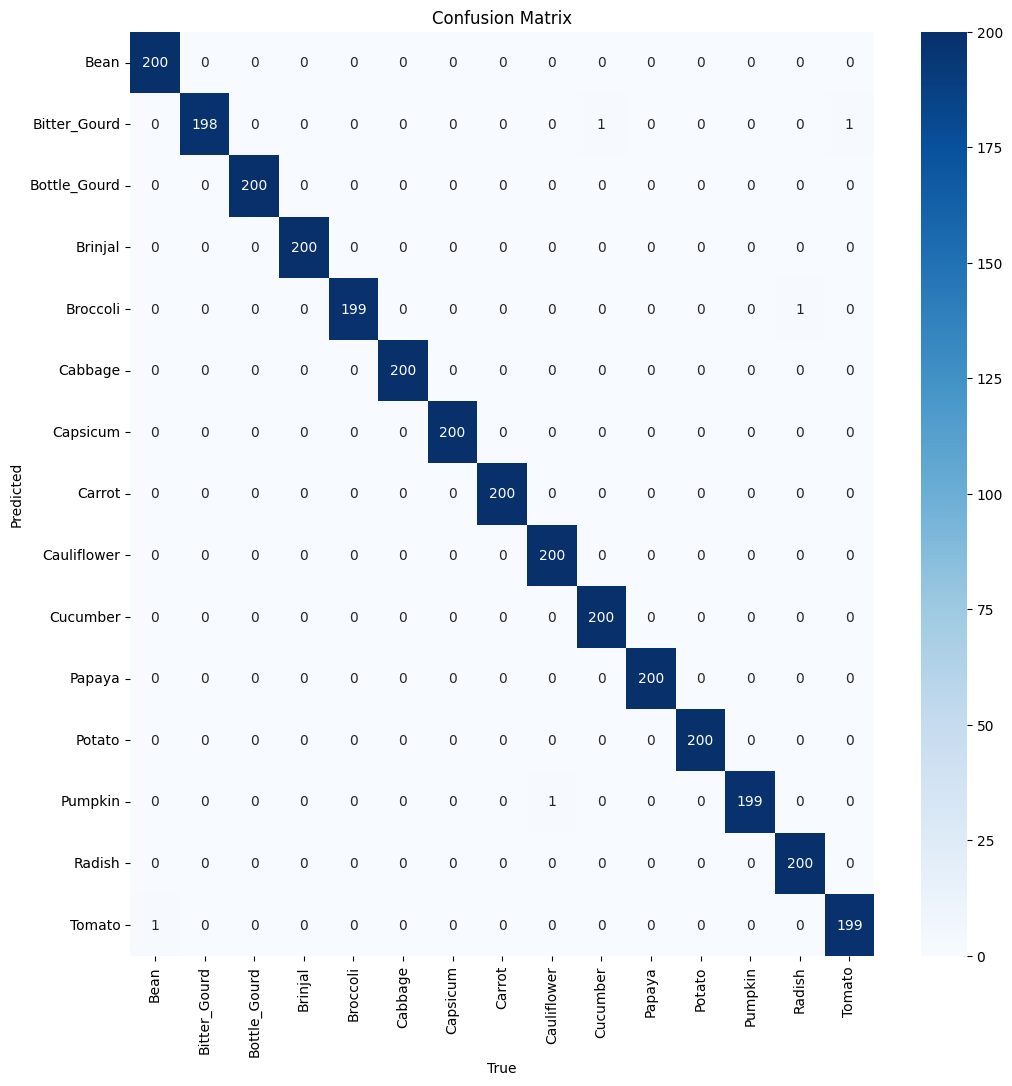

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [ ]:
!pip install pymysql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pymysql
import csv

# Google Drive에 저장된 CSV 로그 파일 경로
log_file_path = '/content/drive/MyDrive/mobilenetv2_fulltunning_training_log.csv'

# MySQL 연결 정보 (각자 환경에 맞게 수정)
mysql_config = {
    'host': 'mysql-37e7717-dkgus439-e1dc.e.aivencloud.com',
    'port': 21739,
    'user': 'avnadmin',
    'password': 'AVNS_yx_y1JMaebzYXmJZ_qH',
    'db': 'defaultdb',
    'charset': 'utf8mb4'
}

# 테이블 생성 쿼리 (이미 존재하면 건너뜁니다.)
create_table_sql = """
CREATE TABLE IF NOT EXISTS mobilenetv2_finetunning_log (
    id INT AUTO_INCREMENT PRIMARY KEY,
    start_time DATETIME,
    end_time DATETIME,
    epoch INT,
    loss FLOAT,
    accuracy FLOAT,
    val_loss FLOAT,
    val_accuracy FLOAT
);
"""

# CSV 파일에서 읽어온 문자열 데이터를 데이터 타입에 맞게 변환하는 함수 예시
def parse_row(row):
    # row: [start_time, end_time, epoch, loss, accuracy, val_loss, val_accuracy]
    # 필요에 따라 날짜 포맷이나 실수 변환을 추가로 적용할 수 있습니다.
    start_time = row[0]
    end_time = row[1]
    epoch = int(row[2])
    loss = float(row[3])
    accuracy = float(row[4])
    val_loss = float(row[5])
    val_accuracy = float(row[6])
    return (start_time, end_time, epoch, loss, accuracy, val_loss, val_accuracy)

try:
    # MySQL 데이터베이스 연결
    conn = pymysql.connect(**mysql_config)

    with conn.cursor() as cursor:
        # 테이블 생성
        cursor.execute(create_table_sql)
        print("테이블 생성 완료 또는 이미 존재합니다.")

        # CSV 파일 열기
        with open(log_file_path, 'r', newline='') as csvfile:
            csv_reader = csv.reader(csvfile)
            header = next(csv_reader)  # 헤더 행 건너뛰기

            # 데이터 삽입 쿼리
            insert_sql = """
                INSERT INTO mobilenetv2_finetunning_log
                (start_time, end_time, epoch, loss, accuracy, val_loss, val_accuracy)
                VALUES (%s, %s, %s, %s, %s, %s, %s)
            """

            for row in csv_reader:
                data = parse_row(row)
                cursor.execute(insert_sql, data)

    # 모든 변경 사항 커밋
    conn.commit()
    print("CSV 로그 데이터가 성공적으로 데이터베이스에 삽입되었습니다.")

except pymysql.Error as e:
    print(f"MySQL 에러: {e}")

except Exception as e:
    print(f"일반 에러: {e}")

finally:
    # 연결 종료
    if conn:
        conn.close()


테이블 생성 완료 또는 이미 존재합니다.
CSV 로그 데이터가 성공적으로 데이터베이스에 삽입되었습니다.
